![](https://i.imgur.com/eBRPvWB.png)

# Tłumaczenie z użyciem sieci Sequence to Sequence z koncentracją


W tym projekcie nauczymy sieć neuronową, jak tłumaczyć z angielskiego na polski.

```
[KEY: > input, = target, < output]

> there are pretty flowers in the garden .
= w ogrodzie są piękne kwiaty .
< w ogrodzie są piękne kwiaty .

> i can't translate this sentence .
= nie potrafię przetłumaczyć tego zdania .
< nie potrafię przetłumaczyć tego zdania .

> how come you know english so well ?
= jak to się stało , że tak dobrze znasz angielski ?
< skąd znasz angielskiego tak dobrze ? 

> things have gotten better now .
= sytuacja się poprawiła .
< to się jeszcze jeszcze teraz lepiej .
```


... z różnym powodzeniem.

Jest to możliwe dzięki prostej, ale potężnej idei sieci [sequence to sequence](http://arxiv.org/abs/1409.3215), w której dwie rekurencyjne sieci neuronowe współpracują ze sobą, aby przekształcić jedną sekwencję w drugą. Sieć kodera kondensuje sekwencję wejściową do pojedynczego wektora, a sieć dekodera rozwija ten wektor w nową sekwencję.

Aby ulepszyć ten model, użyjemy [mechanizmu koncentracji](https://arxiv.org/abs/1409.0473), który pozwoli dekoderowi nauczyć się skupiać na pewnej części sekwencji wejściowej.

# Model Sequence to Sequence


Sieć [Sequence to Sequence](http://arxiv.org/abs/1409.3215) lub sieć seq2seq, lub sieć [Encoder Decoder](https://arxiv.org/pdf/1406.1078v3.pdf), jest to model składający się z dwóch oddzielnych RNN'ów zwanych **koderem** i **dekoderem**. W każdym kroku koder odczytuje sekwencję wejściową po jednym elemencie a oddaje wektor. Końcowy wynik kodera jest utrzymywany jako wektor **kontekstu**. Dekoder wykorzystuje ten wektor kontekstu, aby wytworzyć sekwencję wyjść krok po kroku.

![](https://github.com/wojtekcz/ml_seminars/blob/master/wyklad_nmt/images2/encoder-decoder.png?raw=true)

Podczas korzystania z pojedynczego RNN istnieje relacja jeden do jednego pomiędzy wejściami i wyjściami. Szybko napotkalibyśmy problemy z różnymi kolejnościami sekwencji i długościami, które są częste podczas tłumaczenia. Rozważ proste zdanie "Je ne suis pas le chat noir" & rarr; "I am not the black cat" ("Nie jestem czarnym kotem"). Wiele słów ma całkiem jednoznaczne tłumaczenie, na przykład "cat" &rarr; "kot". Jednak różne gramatyki powodują, że słowa występują w różnych kolejnościach, np. "black cat" &rarr; "kot czarny". Istnieją również konstrukcje "... have gotten better" &rarr; "... się poprawiła", które sprawiają, że dwa zdania mają różne długości.

Model seq2seq, kodując wiele wejść do jednego wektora i dekodując z jednego wektora na wiele wyjść,  uwalnia nas od ograniczeń kolejności i długości sekwencji. Zakodowana sekwencja jest reprezentowana przez pojedynczy wektor, pojedynczy punkt w N-wymiarowej przestrzeni sekwencji. W idealnym przypadku punkt ten można uznać za "znaczenie" sekwencji.

Ten pomysł może zostać przedłużony poza sekwencje. Zadania opisywania obrazów pobierają [obraz jako dane wejściowe i produkują opis](https://arxiv.org/abs/1411.4555) obrazu (img2seq). Niektóre zadania generowania obrazów pobierają [opis jako dane wyjściowe i generują obraz](https://arxiv.org/abs/1511.02793) (seq2img). Takie modele można ogólnie nazwać sieciami "koder dekoder".

## Mechanizm koncentracji (Attention)

Wektor o stałej długości jest odpowiedzialny za zakodowanie całego "znaczenia" sekwencji wejściowej, bez względu na jej długość. Z powodu rożnorodności językowej jest to bardzo trudny problem. Wyobraź sobie dwa prawie identyczne zdania, dwadzieścia słów, różniące się jednym tylko słowem. Zarówno kodery, jak i dekodery muszą być wystarczająco zniuansowane, aby reprezentować tę zmianę jako nieznacznie inny punkt w przestrzeni.

**Mechanizm koncentracji** [wprowadzony przez Bahdanau i innych](https://arxiv.org/abs/1409.0473) rozwiązuje ten problem, dając dekoderowi możliwość "koncentrowania się" na fragmentach danych wejściowych, zamiast polegania na na pojedynczym wektorze. W każdym kroku dekoder może wybrać inny fragment sekwencji wejściowej do rozważenia.

![](https://github.com/wojtekcz/ml_seminars/blob/master/wyklad_nmt/images2/encoder-inputs-decoder-outputs.png?raw=true)

Koncentracja jest obliczana przy użyciu bieżącego stanu ukrytego i każdego wyjścia kodera, aby utworzyć nowy wektor, który ma taki sam rozmiar jak sekwencja wejściowa nazwany *wagami koncentracji*. Te wagi są mnożone przez wyjścia koderów w celu utworzenia nowego wektora *kontekstu*. Wektor kontekstu i stan ukryty jest następnie wykorzystywany do predykcji kolejnego elementu wyjścia.

![](https://github.com/wojtekcz/ml_seminars/blob/master/wyklad_nmt/images2/attention-module-input-output.png?raw=true)

# Wymagania

Będziesz potrzebował [PyTorch](http://pytorch.org/), aby zbudować i wyszkolić modele, i [matplotlib](https://matplotlib.org/), aby wykreślić postęp treningu, a później zwizualizować wyniki koncentracji.

In [4]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
# %matplotlib inline

Tutaj również zdefiniujemy stałą, aby zdecydować, czy użyć GPU (w szczególności z CUDA), czy procesora. **Jeśli nie masz GPU, ustaw tę wartość na `False`**. Później, kiedy stworzymy tensory, zmienna ta będzie używana do decydowania o tym, czy zachowamy je na procesorze, czy przeniesiemy na GPU.

In [5]:
USE_CUDA = False

# Ładowanie plików danych

Dane do tego projektu to zbiór wielu tysięcy par tłumaczeń z angielskiego na polski.

[To pytanie na temat Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) kieruje na serwis ze zbiorem tłumaczeń http://tatoeba.org/ który ma pliki do pobrania dostępne na stronie http://tatoeba.org/eng/downloads - a dodatkowo, ktoś wykonał pracę polegającą na podzieleniu par językowych na poszczególne pliki tekstowe tutaj: http://www.manythings.org/anki/

Potrzebny angielsko-polski plik pobierz używając naszego notebooka konfiguracyjnego. Plik składa się z oddzielonych tabulatorami par tłumaczeń:

```
The cat is black.     Kot jest czarny.
```

Podobnie jak w przypadku kodowania znakowego, używanego w tutorialach "char-rnn-\*", będziemy reprezentować każde słowo w języku jako wektor *1 z n* (ang. one-hot), czyli gigantyczny wektor zer, z wyjątkiem jednej jedynki (na indeksie słowa). W porównaniu z kilkoma dziesiątkami liter, które mogą istnieć w języku, słów istnieje o wiele wiele więcej, więc i wektor kodowania jest znacznie większy. Trochę jednak oszukamy i strymujemy dane, aby użyć tylko kilku tysięcy słów na język.

### Indeksowanie słów

Będziemy potrzebować unikalny indeks dla każdego słowa, który później posłuży jako dane wejściowe i wyjściowe. Aby śledzić to wszystko, użyjemy klasę pomocniczą o nazwie `Lang`, która ma słowniki słowo &rarr; indeks (`word2index`) i indeks &rarr; słowo (`index2word`), a także licznik każdego słowa `word2count`, który można użyć do późniejszego zastąpienia rzadko występujących słów.

In [6]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

### Czytanie i dekodowanie plików

Wszystkie pliki są w Unicode, dla uproszczenia robimy wszystko małymi literami i wycinamy większość znaków interpunkcyjnych.

In [7]:
# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = s.lower().strip()
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s
  
normalize_string('ala ma kota ąćęłńóśźż ĄĆĘŁŃÓŚŹŻ')

'ala ma kota ąćęłńóśźż ąćęłńóśźż'

Aby odczytać plik danych, podzielimy go na linie, a następnie podzielimy linie na pary. Wszystkie pliki są "angielski  &rarr; inny język", więc jeśli chcemy przetłumaczyć z innego języka &rarr; angielski, dodana została flaga `reverse`, aby odwrócić pary.

In [8]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    filename = 'data/seq2seq/%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MIN_LENGTH = 3
MAX_LENGTH = 25
# MIN_LENGTH = 1
# MAX_LENGTH = 100

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

Pełny proces przygotowywania danych to:

* Odczytaj plik tekstowy i podziel na linie, 
* Podziel linie na pary i znormalizuj, 
* Przefiltruj do par o maksymalnej długości
* Stwórz listy słów ze zdań w parach

In [10]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'pol', False)

Reading lines...
Read 36856 sentence pairs
Filtered to 10021 pairs
Indexing words...
Indexed 3246 words in input language, 6104 words in output


### Filtrowanie słowników

Aby coś wytrenować w krócej niż godzinę, strymujmy nieco zestaw danych. Najpierw użyjemy funkcję `trim` w każdym języku (zdefiniowaną wcześniej), aby zachować tylko słowa, które powtarzają się przynajmniej pewną liczbę razy w zestawie danych (co zmniejszy trudność nauczenia się poprawnego tłumaczenia słów, które nie występują często).

In [11]:
MIN_COUNT = 3  # 5
# MIN_COUNT = 2

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 1278 / 3243 = 0.3941
keep_words 1532 / 6101 = 0.2511


### Filtrowanie par

Teraz wrócimy do zbioru wszystkich par zdań i usuniemy te z nieznanymi słowami.

In [12]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Trimmed from 10021 pairs to 4830, 0.4820 of total


## Zamiana danych treningowych na Tensory

Aby trenować, musimy przekształcić zdania w coś, co sieć neuronowa może zrozumieć, co oczywiście oznacza liczby. Każde zdanie zostanie podzielone na słowa i przekształcone w Tensor, gdzie każde słowo zostanie zastąpione indeksem (z wcześniej przygotowanych indeksów językowych). Podczas tworzenia tych tensorów dodamy również token EOS, aby zasygnalizować, że zdanie jest skończone.

![](https://i.imgur.com/LzocpGH.png)

In [13]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

Możemy lepiej wykorzystać GPU, trenując **wsady** (ang. batches) wielu sekwencji naraz, ale czyniąc to, pojawia się pytanie, jak radzić sobie z sekwencjami o różnych długościach. Prostym rozwiązaniem jest "dopełnienie" (ang. padding) krótszych zdań pewnym symbolem dopełnienia (w tym przypadku `0`) i ignorowanie tych dopełnionych miejsc podczas obliczania straty.

![](https://i.imgur.com/gGlkEEF.png)

In [14]:
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

Aby utworzyć zmienną dla pełnego wsadu wejść (i docelowych wyjść), pobieramy losową próbkę sekwencji i dopełniamy je wszystkie do długości najdłuższej sekwencji. Będziemy śledzić długości wszystkich wsadów, aby później usunąć dopełnienie.

Inicjowanie `LongTensor` za pomocą tablicy (wsadów) tablic (sekwencyj) daje nam  `(batch_size x max_len)` tensor - wybór pierwszego wymiaru daje pojedynczy element, który jest pełną sekwencją. Podczas szkolenia modelu będziemy potrzebować jednego kroku naraz, więc przetransponujmy go do `(max_len x batch_size)`. Teraz wybieranie wzdłuż pierwszego wymiaru zwraca jeden krok poprzez wsad.


![](https://github.com/wojtekcz/ml_seminars/blob/master/wyklad_nmt/images2/batch-transpose.png?raw=true)

In [15]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

Możemy przetestować to, aby zobaczyć, że zwróci on tensor `(max_len x batch_size)` dla zdań źródłowych i docelowych, wraz z odpowiadającą im listą długości sekwencji (które wykorzystamy później do maskowania).

In [16]:
random_batch(2)

(tensor([[ 701,  261],
         [  82,  813],
         [ 385,    4],
         [   8,    2],
         [   2,    0]]), [5, 4], tensor([[  19,  353],
         [ 239,  183],
         [ 392,    4],
         [   8,    2],
         [   2,    0]]), [5, 4])

# Budowanie modeli

## Koder

<img src="https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/images/encoder-network.png?raw=true" style="float: right" />

Koder pobierze wsad sekwencji słów, `LongTensor` o rozmiarze `(max_len x batch_size)` i odda kodowanie dla każdego słowa, `FloatTensor` o rozmiarze `(max_len x batch_size x hidden_size)`.

Słowne dane wejściowe są podawane przez [warstwę osadzającą `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding) w celu utworzenia osadzenia dla każdego słowa, o rozmiarze `seq_len x hidden_size` (jakby to był wsad słów). Jest to zmieniane na `seq_len x 1 x hidden_size`, aby pasowało do oczekiwanego wejścia [warstwy GRU` nn.GRU`](http://pytorch.org/docs/nn.html#gru). GRU zwróci zarówno sekwencję wyjściową o rozmiarze `seq_len x hidden_size` jak i ukryty stan.



In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

## Dekoder z koncentracją

### Interpretacja modelu Bahdanau

Publikacja [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) (Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio) wprowadziła ideę użycia koncentracji przy tłumaczeniu seq2seq.

Każde wyjście dekodera jest uwarunkowane poprzednimi wyjściami i pewnym $\mathbf x$, gdzie $\mathbf x $składa się z bieżącego stanu ukrytego (który bierze pod uwagę poprzednie wyjścia) i "kontekstu" koncentracji, który jest obliczany poniżej. Funkcja $g$ jest w pełni połączoną warstwą z nieliniową aktywacją, która jako dane wejściowe przyjmuje połączone wartości $y_{i-1}$, $s_i$ i $c_i$.


$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

Bieżący stan ukryty $s_i$ jest obliczany przez RNN $f$ z ostatnim ukrytym stanem $s_{i-1}$, ostatnią wartością wyjściową dekodera $y_{i-1}$  i wektorem kontekstu $c_i$.
W kodzie RNN będzie warstwą `nn.GRU`, ukryty stan $s_i$ będzie nazywany `hidden`, wyjście $y_i$ zwane `output` oraz kontekst $c_i$ zwany `context`.


$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Wektor kontekstu $c_i$ jest sumą ważoną wszystkich wyników kodera, gdzie każda waga $a_{ij}$ jest ilością "koncentracji" przekazanej na odpowiednie wyjście kodera $h_j$.


$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... gdzie każda waga $a_{ij}$ to znormalizowana (poprzez wszystkie kroki) "energia" koncentracji $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... gdzie każda energia koncentracji jest obliczana za pomocą funkcji $a$ (takiej jak inna warstwa liniowa) przy użyciu ostatniego ukrytego stanu $s_{i-1}$ i tego konkretnego wyjścia kodera $h_j$:

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Interpretacja modelu Luonga

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) autorstwa Luonga i innych opisuje kilka modeli koncentracji, które oferują ulepszenia i uproszczenia. Autorzy opisują kilka modeli "globalnej koncentracji", rozróżnianych przez sposób obliczania wyników koncentracji.

Ogólna forma obliczania koncentracji opiera się na ukrytym stanie po stronie docelowej (dekodera) i odpowiednim stanie bocznym źródła (kodera), znormalizowanym dla wszystkich stanów, aby uzyskać wartości zsumowane do 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

Konkretną funkcją "oceny" (score), która porównuje dwa stany, jest albo *dot*, iloczyn skalarny między stanami; *general*, iloczyn skalarny między ukrytym stanem dekodera a liniową transformacją stanu kodera; lub *concat*, iloczyn skalarny między nowym parametrem $v_a$ a liniową transformacją stanów połączonych ze sobą.


$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

Modularna definicja tych funkcji ewaluacji daje nam możliwość zbudowania specjalnego modułu koncentracji, który może przełączać się między różnymi metodami oceny. Wejście do tego modułu to zawsze stan ukryty (dekodera RNN) i zestaw wyjść kodera.


### Implementacja modułu koncentracji

In [18]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies, dim=-1).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

### Implementacja modelu Bahdanau

Podsumowując, nasz dekoder powinien składać się z czterech głównych części - warstwy osadzającej, zamieniającej słowo wejściowe w wektor; warstwy do obliczenia energii koncentracji na wyjście kodera; warstwy RNN; i warstwt wyjściowej.

Wejścia dekodera to ostatni ukryty stan RNN $s_{i-1}$, ostatnie wyjście $y_{i-1}$ oraz wszystkie wyjścia kodera $h_*$.

* warstwa osadzająca z wejściami $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* warstwa koncentracji $a$ z wejściami $(s_{i-1}, h_j)$ i wyjściami $e_{ij}$, znormalizowanymi w celu utworzenia $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* wektor kontekstowy $c_i$ jako średnia ważona wyjść kodera
    * `context = sum(attn_weights * encoder_outputs)`
* warstwa (warstwy) RNN $f$ z wejściami $(s_{i-1}, y_{i-1}, c_i)$ i wewnętrznym stanem ukrytym, oddaje $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* warstwa wyjściowa $g$ z wejściami $(y_{i-1}, s_i, c_i)$, oddaje $y_i$
    * `output = out(embedded, rnn_output, context)`



In [19]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)), dim=-1)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

Teraz możemy zbudować dekoder, który podłącza ten moduł Attn za RNN, aby obliczyć wagi koncentracji, i zastosować te wagi do wyjść kodera, aby uzyskać wektor kontekstu.


In [20]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

## Testowanie modeli

Aby upewnić się, że moduły kodera i dekodera działają (i współpracują ze sobą), wykonamy pełny test przy pomocy małego wsadu.

In [68]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([6, 3])
target_batches torch.Size([6, 3])


Twórz modele o małym rozmiarze (można je kontrolować wzrokowo):

In [69]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

Aby przetestować, przepuść przez koder wsad wejściowy, aby uzyskać wyjścia kodera per-wsad:

In [70]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([6, 3, 8])
encoder_hidden torch.Size([4, 3, 8])


In [72]:
import torch
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace

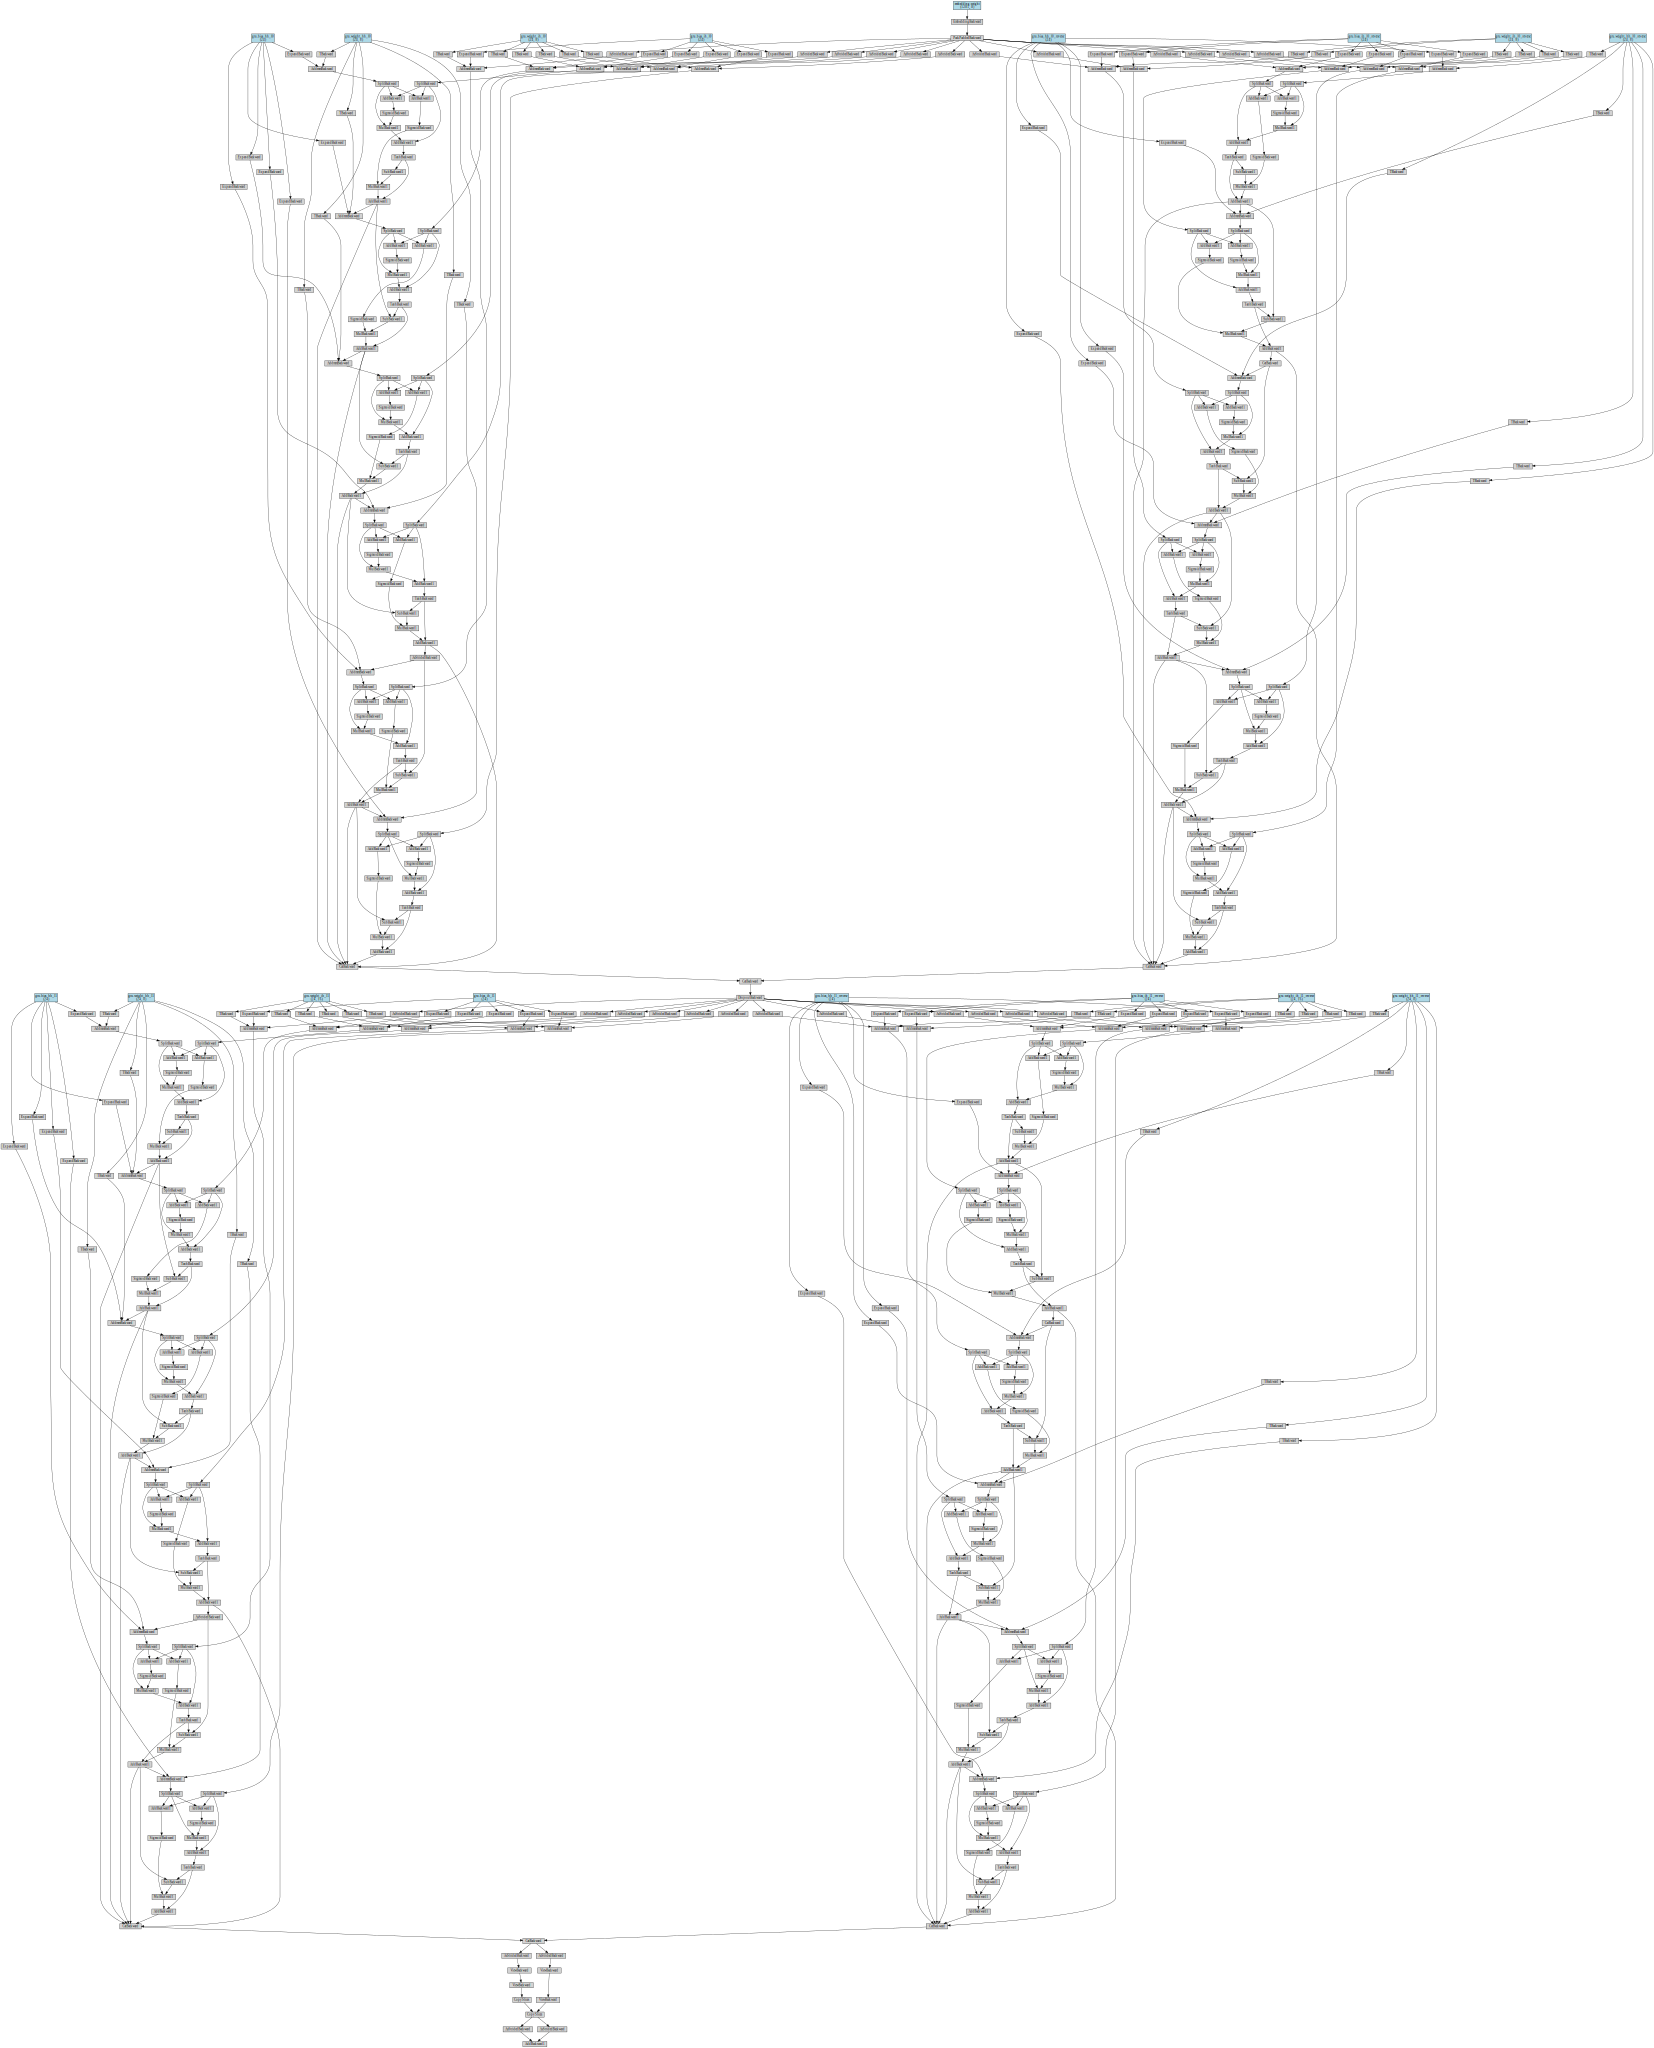

In [85]:
make_dot(encoder_outputs, params=dict(encoder_test.named_parameters()))

In [84]:
type(encoder_test)

__main__.EncoderRNN

In [86]:
trace, _ = torch.jit.trace(encoder_test, args=(input_batches, input_lengths,))
make_dot_from_trace(trace)

TypeError: 'function' object is not iterable

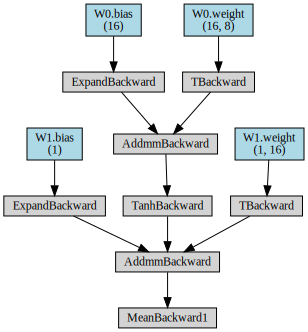

In [87]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = Variable(torch.randn(1,8))
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters()))

In [90]:
trace, _ = torch.jit.trace(model)
make_dot_from_trace(trace)

TypeError: 'function' object is not iterable

Następnie zaczynając od tokena SOS, przepuść słowne tokeny przez dekoder, aby uzyskać każdy następny token. Zamiast robić to z całą sekwencją, robi się to po jednym tokenie na raz, aby wesprzeć używanie jego własnych prognoz do wykonania następnej prognozy. Będzie to tylko jeden krok, ale obejmujący cały wsad. Aby to zadziałało w przypadku krótkich sekwencji, wielkość wsadu będzie się zmniejszać za każdym razem.

In [77]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
print('loss', loss.item())

loss 7.376188278198242


In [79]:
# make_dot(decoder_output, params=dict(decoder_test.named_parameters()))

# trace, _ = torch.jit.trace(model, args=(x,))

KeyError: 4763138232

# Trenowanie

## Definiowanie iteracji treningu

Aby trenować, najpierw przepuszczamy zdanie wejściowe przez koder słowo po słowie i śledzimy każde wyjście i ostatni stan ukryty. Następnie dekoder otrzymuje ostatni ukryty stan dekodera jako swój pierwszy ukryty stan, a token `<SOS>` jako pierwsze wejście. Następnie iterujemy aby prognozować następny token z dekodera.

### "Teacher Forcing" kontra Scheduled Sampling

"Teacher Forcing" lub pobieranie próbek o największej wiarygodności oznacza wykorzystanie rzeczywistych wyników docelowych jako każdego następnego wejścia podczas treningu. Alternatywą jest użycie własnego odgadnięcia przez dekoder jako następnego wejścia. Korzystanie z wymuszania nauczyciela może spowodować szybsze zbieganie się sieci, ale [kiedy wyszkolona sieć jest wykorzystywana, może wykazywać niestabilność](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

Możesz obserwować wyniki wymuszonych przez nauczyciela sieci, które czytają ze spójną gramatyką, ale oddalają się od prawidłowego tłumaczenia - możesz myśleć o tym, że nauczyłeś się słuchać instrukcji nauczyciela, nie ucząc się samodzielnego wyjścia.

Rozwiązanie "problemu" teacher-forcing jest znane jako [Zaplanowane próbkowanie (ang. Scheduled Sampling)](https://arxiv.org/abs/1506.03099), które po prostu przełącza się między wartościami docelowymi i prognozowanymi wartościami podczas trenowania. My losowo wybieramy użycie wymuszania nauczyciela instrukcją if podczas treningu - czasami będziemy podawać rzeczywisty cel jako wejście (ignorując wyjście dekodera), czasami użyjemy wyjścia dekodera.


In [25]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item(), ec, dc  

## Uruchamianie treningu

Gdy wszystko jest gotowe, możemy zainicjować sieć i rozpocząć trening.

Na początek inicjujemy modele, optymalizatory, funkcję straty (kryterium), i ustawiamy zmienne dla kreślenia i śledzenia postępu.

In [54]:
# Configure models
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 50 # 1600  # 100
# batch_size = 50

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 1000 # 50000
epoch = 0
plot_every = 10
print_every = 50  # 100
evaluate_every = 50 # 1000

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

In [ ]:
make_dot(y.mean(), params=dict(model.named_parameters()))

In [55]:
from torchnet.logger import VisdomPlotLogger, VisdomLogger, VisdomTextLogger
from tqdm import tqdm
import io
import json
from tensorboardX import SummaryWriter

In [63]:
# Start a job

class Job:
    def __init__(self, name, params={}, hostname='localhost', port=8890, n_epochs=10):
        self.name = name
        self.params = params
        self.hostname = hostname
        self.port = port
        self.avg_train_loss_logger = VisdomPlotLogger(
        'line', port=port, opts={'title': f'{name}_Train Loss'})
        self.job_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Job Info'})
        self.log_logger = VisdomTextLogger(port=port, opts={'title': f'{name}_Train Loss Log'}, update_type='APPEND')
        self.pbar = tqdm(total=n_epochs, ncols=60, mininterval=1.0, ascii=True, file=io.StringIO())
        self.progress_logger = VisdomTextLogger(port=port, opts=dict(title=f'{name}_Progress Bar',
            width=500,
            height=50,
        ))
        self.summary_writer = SummaryWriter(log_dir='data/tmp/runs/', comment=name)

        self.start()

    def start(self):
        j_str = json.dumps(self.params, indent=4)
        j_str = j_str.replace('\n', '<br/>\n').replace(' ', '&nbsp;')
        self.job_logger.log(f'{j_str}')

        self.job_id = '#job_id'# body['id']
        print("Starting job %s at %s" % (self.job_id, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())))
        self.start_time = time.time()

        self.log_every = 50
        self.plot_every = 50
        self.loss_avg = 0

    def stop(self, ):
        j = {'status': 'done'}
        print(j)
        self.summary_writer.close()

    def log(self, l):
        def time_since(since):
            now = time.time()
            s = now - since
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        self.log_logger.log(l)

    def plot(self, x, y):
        self.avg_train_loss_logger.log(x, y)
    
    def record(self, e, loss):
        self.loss_avg += loss

        if e > 0 and e % self.log_every == 0:
            self.log('(%s) %.4f' % (e, loss))

        if e > 0 and e % self.plot_every == 0:
            self.plot(e, self.loss_avg / self.plot_every)
            self.loss_avg = 0
            
        self.summary_writer.add_scalar('loss', loss, e)

    def update_progress(self, ):
        self.pbar.update(1)
        text = f'{self.pbar}'.replace(' ', '<font color="white">#</font>')
        self.progress_logger.log(text)

In [64]:
job = Job('seq2seq-translate', {
    'attn_model': attn_model,
    'n_layers': n_layers,
    'dropout': dropout,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'clip': clip,
    'teacher_forcing_ratio': teacher_forcing_ratio,
    'decoder_learning_ratio': decoder_learning_ratio,
}, n_epochs=n_epochs)
job.plot_every = plot_every
job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

import visdom

vis = visdom.Visdom(port=job.port)

Starting job #job_id at 2018-05-15 13:03:53


In [65]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Ewaluacja sieci

Ewaluacja jest w większości taka sama jak trening, z tym że bez danych docelowych. Zamiast tego zawsze podajemy prognozy dekodera z powrotem do niego. Za każdym razem, gdy prognozuje słowo, dodajemy je do łańcucha wyjściowego. Jeśli dekoder prognozuje token EOS, kończymy. Przechowujemy także wyniki koncentracji dekodera dla każdego kroku, aby je później wyświetlić.


In [41]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths = [len(input_seqs[0])]

    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)

    if USE_CUDA:
        input_batches = input_batches.cuda()

    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)

    # Run through encoder
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

    # Run through decoder
    for di in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])

        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

Możemy oceniać losowo wybrane zdania z zestawu treningowego i wyświetlić dane wejściowe, docelowe i wyjściowe w celu dokonania subiektywnej oceny jakości:

In [42]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# Wizualizacja koncentracji

Użyteczną właściwością mechanizmu koncentracji są jego wysoce interpretowalne wyniki. Ponieważ jest on używany do "ważenia" poszczególnych wyjść kodera dla sekwencji wejściowej, możemy sobie wyobrazić, na czym sieć skupia się w każdym kroku.

Możesz po prostu wywołać `plt.matshow(attentions)`, aby zobaczyć wyniki koncentracji wyświetlone jako matryca, z kolumnami będącymi krokami wejściowymi i wierszami będącymi krokami wyjściowymi:

In [43]:
import io
import torchvision
from PIL import Image

Aby uzyskać lepszy efekt wizualny, dodamy osie i etykiety:

In [44]:
def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [45]:
def show_attention(input_sentence, output_words, attentions):
    mpl.style.use('default')
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    cax = ax.matshow(attentions.numpy(), cmap='jet')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [46]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

# Składamy wszystko razem

Żeby przeprowadzić właściwy trening, wielokrotnie wywołujemy funkcję treningową i wyświetlamy podsumowanie w trakcie.

*Zauważ:* w trakcie pracy z tyme notatnikiem możesz **trenować, przerywać, ewaluować i wracać tutaj, by kontynuować trening**. Po prostu wykonaj pozostałą część notatnika zaczynając od następnej komórki (wykonanie od poprzedniej komórki zresetuje modele).

In [49]:
job.summary_writer.close()
job.summary_writer


  4%|9                    | 43/1000 [01:09<21:36,  1.35s/it]
1m 9s (- 22m 5s) (50 5%) 3.7176
> where's my husband ?
= gdzie jest mój mąż ?
< to ? <EOS>


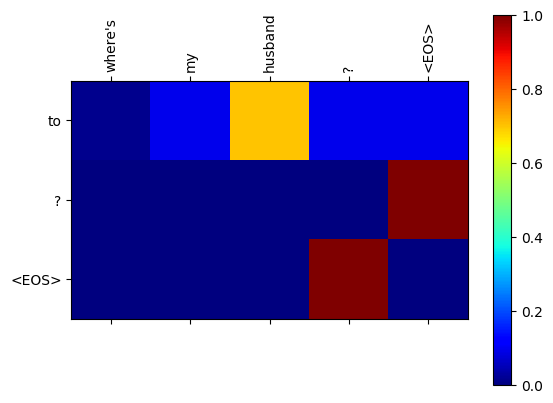

  9%|#9                   | 93/1000 [02:18<21:11,  1.40s/it]
2m 18s (- 20m 42s) (100 10%) 4.0964
> i don't sing .
= nie śpiewam .
< tom jest . <EOS>


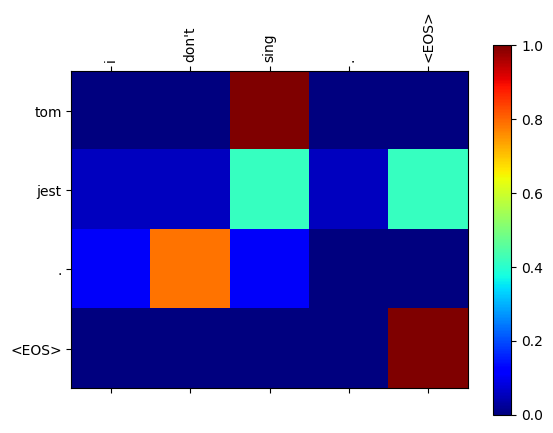

 14%|##8                 | 143/1000 [03:29<20:38,  1.44s/it]
3m 29s (- 19m 45s) (150 15%) 3.8666
> tom likes you .
= tom cię lubi .
< tom nie nie nie nie nie nie nie . <EOS>


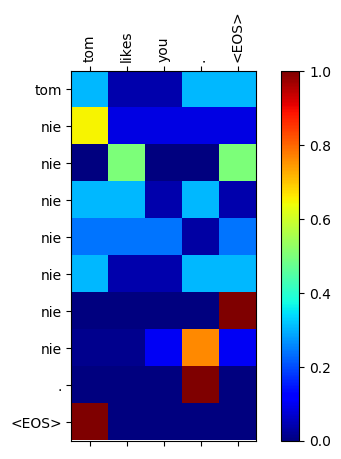

 19%|###8                | 193/1000 [04:41<18:11,  1.35s/it]
4m 41s (- 18m 44s) (200 20%) 3.7261
> i don't work for anyone .
= nie pracuję dla nikogo .
< nie nie nie nie nie nie nie . <EOS>


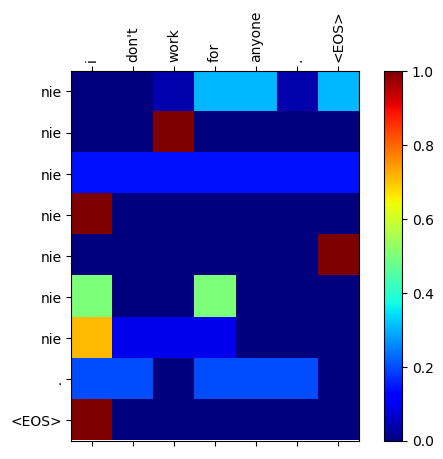

 24%|####8               | 243/1000 [05:52<17:51,  1.41s/it]
5m 52s (- 17m 36s) (250 25%) 3.6510
> can you repair this ?
= umiesz to naprawić ?
< czy to jest ? <EOS>


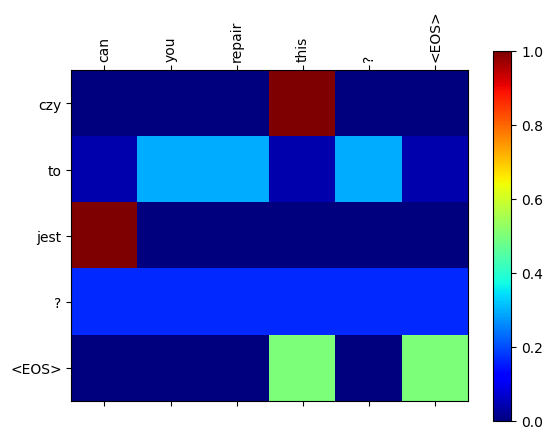

 29%|#####8              | 293/1000 [07:01<16:54,  1.44s/it]
7m 1s (- 16m 22s) (300 30%) 3.5974
> i also went .
= ja także poszłam .
< nie nie nie nie nie . <EOS>


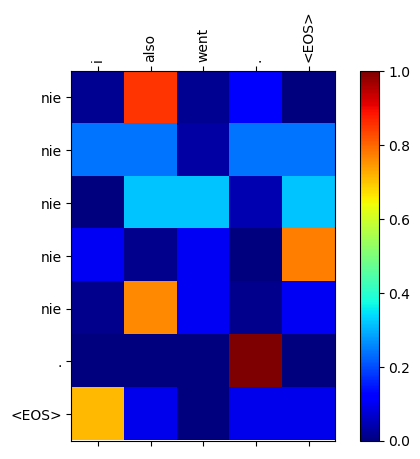

 34%|######8             | 343/1000 [08:12<15:23,  1.40s/it]
8m 12s (- 15m 15s) (350 35%) 3.5342
> this was a lie .
= to było kłamstwo .
< tom jest nie nie nie . <EOS>


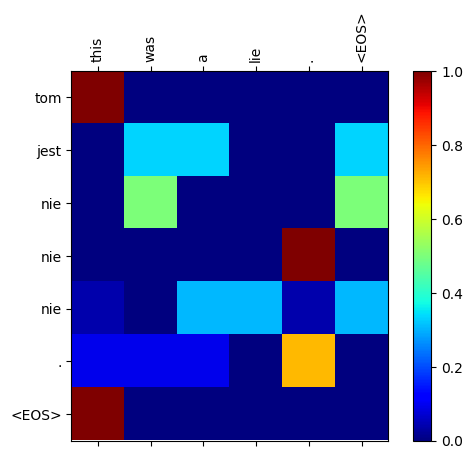

 39%|#######8            | 393/1000 [09:23<14:06,  1.39s/it]
9m 23s (- 14m 5s) (400 40%) 3.5078
> it's our car .
= to nasz samochód .
< nie nie nie jest nie jest . <EOS>


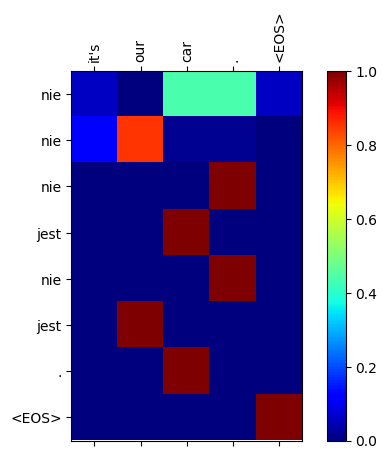

 44%|########8           | 443/1000 [10:33<12:48,  1.38s/it]
10m 33s (- 12m 54s) (450 45%) 3.4123
> he went in place of me .
= pojechał za mnie .
< nie nie nie nie nie nie nie nie nie nie nie nie nie nie . <EOS>


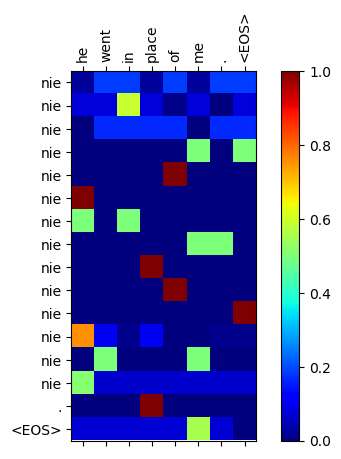

 49%|#########8          | 493/1000 [11:45<11:28,  1.36s/it]
11m 45s (- 11m 45s) (500 50%) 3.3965
> what's our plan ?
= jaki mamy plan ?
< czy to jest ? <EOS>


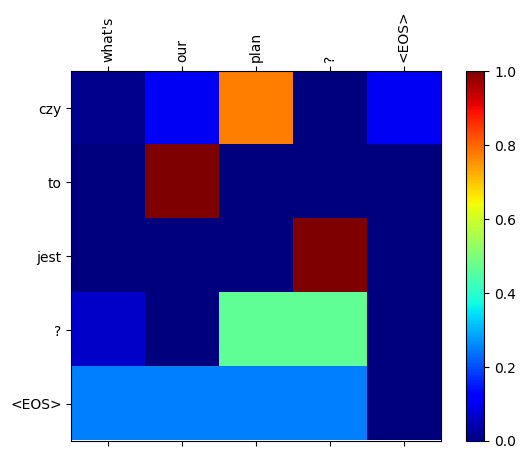

 54%|##########8         | 543/1000 [12:57<09:58,  1.31s/it]
12m 57s (- 10m 35s) (550 55%) 3.3633
> he lost his job .
= on stracił swoją pracę .
< nie nie nie nie nie nie nie nie nie nie nie nie . <EOS>


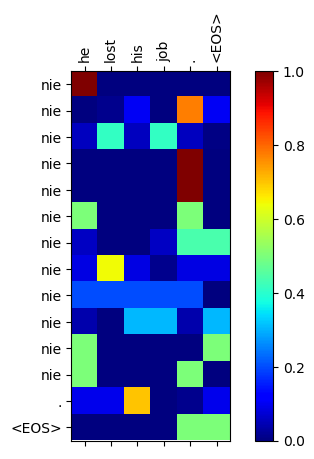

 59%|###########8        | 593/1000 [14:09<10:16,  1.52s/it]
14m 9s (- 9m 26s) (600 60%) 3.3505
> it's new .
= to jest nowe .
< to jest . <EOS>


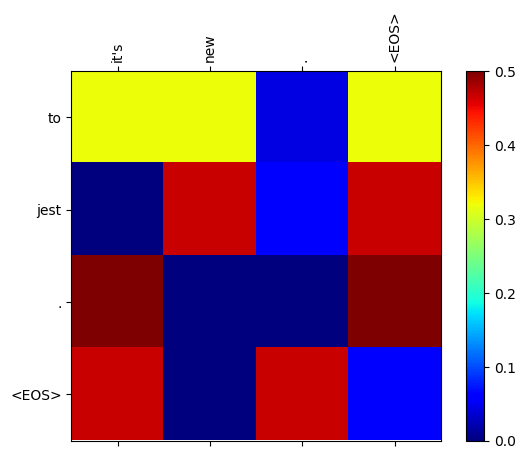

 64%|############8       | 643/1000 [15:21<07:46,  1.31s/it]
15m 21s (- 8m 16s) (650 65%) 3.2980
> what happened in here ?
= co tu się stało ?
< co to jest ? <EOS>


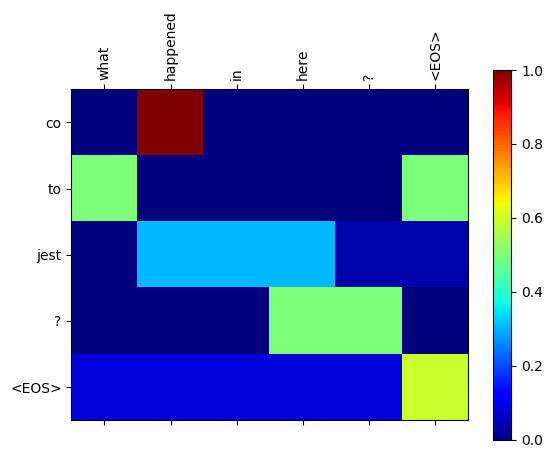

 69%|#############8      | 693/1000 [16:37<07:38,  1.49s/it]
16m 37s (- 7m 7s) (700 70%) 3.2601
> tom didn't like mary .
= tom nie lubił mary .
< tom jest się się . <EOS>


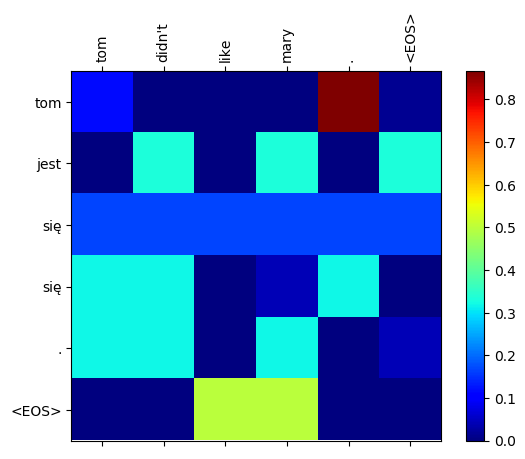

 74%|##############8     | 743/1000 [17:52<06:15,  1.46s/it]
17m 52s (- 5m 57s) (750 75%) 3.1679
> how's the weather there ?
= jaka jest tam pogoda ?
< czy to jest ? <EOS>


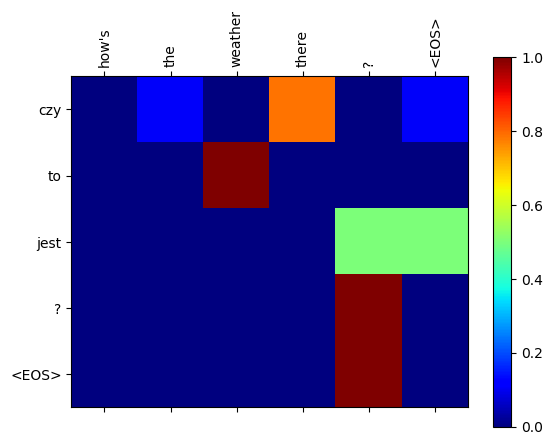

KeyboardInterrupt: 

In [66]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    
    job.record(epoch, loss)
    job.update_progress()

    if epoch % print_every == 0:
        print(f'{job.pbar}')
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

## Wyrysowywanie strat treningowych

Wykreślanie odbywa się za pomocą matplotlib, przy użyciu tablicy `plot_losses`, która została utworzona podczas treningu.


In [ ]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [ ]:
MIN_COUNT = 3  # 5
xxx=[print(random.choice(pairs)) for i in range(10)]

In [ ]:
output_words, attentions = evaluate("it's time for lunch .")
plt.matshow(attentions.numpy())
show_plot_visdom()

['i failed after all .', 'nie udało mi się jednak .']
['i like you very much .', 'bardzo cię lubię .']
["i can't leave .", 'nie mogę wyjść .']
['i feel very good .', 'czuję się bardzo dobrze .']
["we've been here an hour .", 'jesteśmy tutaj godzinę .']
["i don't like it .", 'nie lubię tego .']
['tom likes boston .', 'tom lubi boston .']
['that works .', 'to działa .']
['i will try it again .', 'spróbuję ponownie .']
['tom drank some beer .', 'tom wypił piwo .']

In [ ]:
evaluate_and_show_attention('i failed after all .', 'nie udało mi się jednak .')

In [ ]:
evaluate_and_show_attention('i like you very much .', 'bardzo cię lubię .')

In [ ]:
evaluate_and_show_attention("i can't leave .", 'nie mogę wyjść .')

In [ ]:
evaluate_and_show_attention('i feel very good .', 'czuję się bardzo dobrze .')

In [ ]:
evaluate_and_show_attention("we've been here an hour .", 'jesteśmy tutaj godzinę .')

In [ ]:
evaluate_and_show_attention("i don't like it .", 'nie lubię tego .')

# Zapis modelu

In [ ]:
# model: encoder, decoder, vocab: lang1, lang2

In [ ]:
encoder.state_dict

In [ ]:
decoder.state_dict

In [ ]:
ls -lah data/seq2seq/tmp

In [ ]:
from pathlib import Path
import pickle
dataset_path = Path('data/seq2seq')
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [ ]:
VOCAB, ENCODER, DECODER = ['vocab', 'encoder', 'decoder']
fn_trn1 = {VOCAB: 'eng-pol.vocab.1.p', \
           ENCODER: 'batched.encoder.h500.l2.e10000.gpu.torch', \
           DECODER: 'batched.decoder.h500.l2.e10000.gpu.torch'
          }
fn_dict = fn_trn1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

torch.save(encoder, tmp_path / fn_dict[ENCODER])
torch.save(decoder, tmp_path / fn_dict[DECODER])

In [ ]:
# save vocab

vocab = {'input_lang': input_lang, 'output_lang': output_lang}

pickle.dump(vocab, open(tmp_path / fn_dict[VOCAB], 'wb'))

In [ ]:
ls -lah $tmp_path

# Ćwiczenia

* Spróbuj użyć inny zestaw danych
    * Inna para języków
    * Człowiek &rarr; Maszyna (np. Komendy IOT)
    * Czat &rarr; Odpowiedź
    * Pytanie &rarr; Odpowiedź
* Zastąp zastosowane osadzenie przetrenowanymi wcześniej osadzeniami, takimi jak word2vec lub GloVe
* Wypróbuj więcej warstw, więcej ukrytych jednostek i więcej zdań. Porównaj czas trenowania i wyniki.
* Jeśli używasz pliku tłumaczenia, w którym pary mają dwie takie same frazy (`I am test \t I am test`), możesz użyć tego jako autoencoder. Spróbuj tego:
    * Trenuj jako autoencoder
    * Zapisz tylko sieć kodera
    * Wytrenuj nowy dekoder do tłumaczenia, wykorzystując wcześniej wytrenowany koder
